# PDF Text Classification with XGBoost
## Identifying H1 Headings and Titles from PDF Text

This notebook implements an **XGBoost classifier** to identify H1 headings and titles from PDF text using both text content and metadata features.

### Dataset Overview:
- **Total samples**: 67,913
- **Classes**: 
  - Normal text: 66,393 (97.8%)
  - H1 headings: 1,141 (1.7%)
  - Titles: 379 (0.6%)
- **Challenge**: Highly imbalanced dataset (175:1 ratio)

### Approach:
1. **Text Features**: TF-IDF vectorization of content
2. **Metadata Features**: Font size, formatting (bold/italic), text length
3. **Class Imbalance**: SMOTE oversampling + XGBoost scale_pos_weight
4. **Evaluation**: F1-score focused (accuracy would be misleading)

---

In [2]:
# Import required libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from collections import Counter
import warnings
warnings.filterwarnings('ignore')

# Scikit-learn imports
from sklearn.model_selection import train_test_split, cross_val_score, StratifiedKFold, GridSearchCV
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.metrics import classification_report, confusion_matrix, f1_score
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression

# XGBoost
import xgboost as xgb
from xgboost import XGBClassifier

# Imbalanced-learn for SMOTE
try:
    from imblearn.over_sampling import SMOTE
    from imblearn.pipeline import Pipeline as ImbPipeline
    HAS_SMOTE = True
    print("✅ SMOTE available for handling class imbalance")
except ImportError:
    HAS_SMOTE = False
    print("⚠️ SMOTE not available. Installing imbalanced-learn...")
    import subprocess
    import sys
    
    # Install the package
    subprocess.check_call([sys.executable, "-m", "pip", "install", "imbalanced-learn"])
    
    # Try importing again
    try:
        from imblearn.over_sampling import SMOTE
        from imblearn.pipeline import Pipeline as ImbPipeline
        HAS_SMOTE = True
        print("✅ SMOTE installed and imported successfully!")
    except ImportError:
        print("❌ Failed to import SMOTE even after installation. Using class weights instead.")
        HAS_SMOTE = False

# Set style for plots
plt.style.use('default')
sns.set_palette("husl")

print("📚 All libraries imported successfully!")
print(f"🔥 XGBoost version: {xgb.__version__}")
print(f"🐼 Pandas version: {pd.__version__}")
print(f"🔢 NumPy version: {np.__version__}")

✅ SMOTE available for handling class imbalance
📚 All libraries imported successfully!
🔥 XGBoost version: 2.1.4
🐼 Pandas version: 2.3.1
🔢 NumPy version: 2.2.6


# 1. Load and Explore Dataset 📊

Let's load the labeled dataset and perform initial exploration to understand the data structure and class distribution.

In [3]:
# Load the dataset
print("Loading labeled dataset...")
df = pd.read_csv('labeled_dataset.csv')

# Basic dataset info
print(f"📊 Dataset shape: {df.shape}")
print(f"📁 Columns: {list(df.columns)}")
print(f"💾 Memory usage: {df.memory_usage(deep=True).sum() / 1024**2:.1f} MB")

# Check for missing values
print(f"\n🔍 Missing values:")
missing_counts = df.isnull().sum()
for col, count in missing_counts.items():
    if count > 0:
        print(f"  {col}: {count} ({count/len(df)*100:.1f}%)")

# Display first few rows
print(f"\n📋 First 5 rows:")
df.head()

Loading labeled dataset...
📊 Dataset shape: (67913, 14)
📁 Columns: ['file_name', 'text', 'page_number', 'font_size', 'font_name', 'is_bold', 'is_italic', 'is_title', 'is_h1', 'x1', 'y1', 'x2', 'y2', 'total_pages']
💾 Memory usage: 20.5 MB

🔍 Missing values:
  text: 78 (0.1%)

📋 First 5 rows:
📊 Dataset shape: (67913, 14)
📁 Columns: ['file_name', 'text', 'page_number', 'font_size', 'font_name', 'is_bold', 'is_italic', 'is_title', 'is_h1', 'x1', 'y1', 'x2', 'y2', 'total_pages']
💾 Memory usage: 20.5 MB

🔍 Missing values:
  text: 78 (0.1%)

📋 First 5 rows:


,file_name,text,page_number,font_size,font_name,is_bold,is_italic,is_title,is_h1,x1,y1,x2,y2,total_pages
0,0a29925ccc5e6299e132a73325956a3abef6dd26.pdf,Somalia Flood Exposure Methodology Note,1,16.0,RobotoSlab-Bold,True,False,True,False,72.0,142.344376,401.462585,163.445938,2
1,0a29925ccc5e6299e132a73325956a3abef6dd26.pdf,Analysis for 2024 HNRP,1,16.0,RobotoSlab-Regular,False,False,False,False,72.0,170.344376,253.265884,191.445938,2
2,0a29925ccc5e6299e132a73325956a3abef6dd26.pdf,This technical note summarises the methodology...,1,11.0,Roboto-Regular,False,False,False,False,72.0,238.854919,539.314453,251.745544,2
3,0a29925ccc5e6299e132a73325956a3abef6dd26.pdf,potentially exposed to flooding in Somalia in ...,1,11.0,Roboto-Regular,False,False,False,False,72.0,253.854919,539.772339,266.745544,2
4,0a29925ccc5e6299e132a73325956a3abef6dd26.pdf,Response Plan (,1,11.0,Roboto-Regular,False,False,False,False,72.0,268.854919,152.602493,281.745544,2


🎯 Class Distribution:
  normal: 66,393 (97.8%)
  h1: 1,141 (1.7%)
  title: 379 (0.6%)

⚖️ Imbalance Ratio: 175.2:1


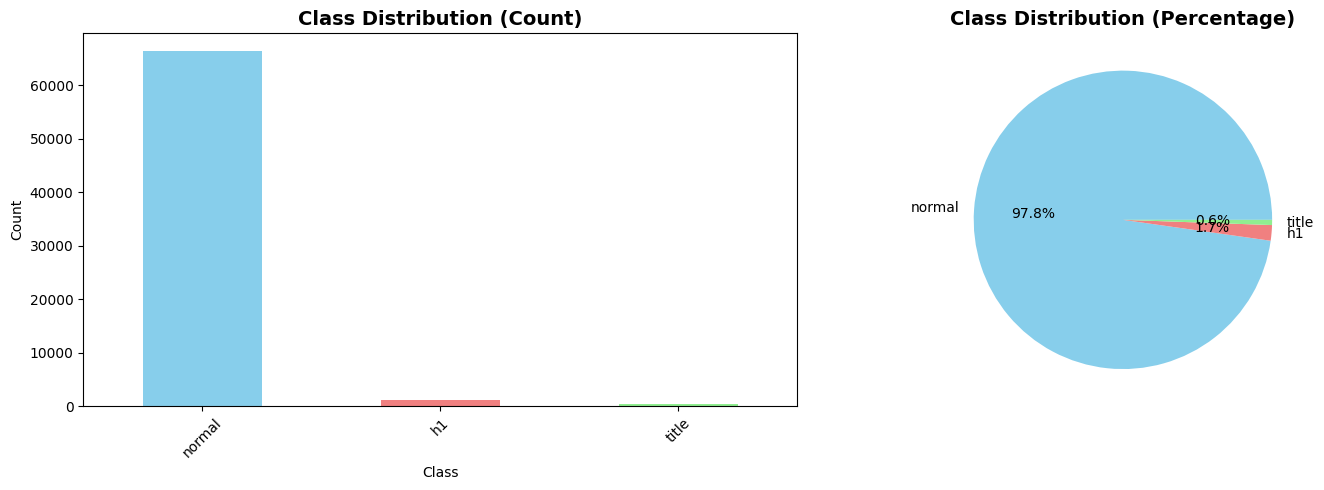

🚨 This is a highly imbalanced classification problem!
💡 We'll need to use techniques like SMOTE and class weights.


In [4]:
# Create target variable and analyze class distribution
df['label'] = df.apply(lambda row: 'title' if row['is_title'] 
                      else ('h1' if row['is_h1'] else 'normal'), axis=1)

# Class distribution
class_dist = df['label'].value_counts()
print("🎯 Class Distribution:")
for label, count in class_dist.items():
    percentage = (count / len(df)) * 100
    print(f"  {label}: {count:,} ({percentage:.1f}%)")

# Calculate imbalance ratio
majority_class = class_dist.max()
minority_class = class_dist.min()
imbalance_ratio = majority_class / minority_class
print(f"\n⚖️ Imbalance Ratio: {imbalance_ratio:.1f}:1")

# Visualize class distribution
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))

# Bar plot
class_dist.plot(kind='bar', ax=ax1, color=['skyblue', 'lightcoral', 'lightgreen'])
ax1.set_title('Class Distribution (Count)', fontsize=14, fontweight='bold')
ax1.set_xlabel('Class')
ax1.set_ylabel('Count')
ax1.tick_params(axis='x', rotation=45)

# Pie chart
ax2.pie(class_dist.values, labels=class_dist.index, autopct='%1.1f%%', 
        colors=['skyblue', 'lightcoral', 'lightgreen'])
ax2.set_title('Class Distribution (Percentage)', fontsize=14, fontweight='bold')

plt.tight_layout()
plt.show()

print("🚨 This is a highly imbalanced classification problem!")
print("💡 We'll need to use techniques like SMOTE and class weights.")

In [5]:
# Analyze key features by class
print("🔍 Feature Analysis by Class:")
print("=" * 50)

# Handle missing values first
df['text'] = df['text'].fillna('')
df['font_size'] = df['font_size'].fillna(df['font_size'].median())
df['is_bold'] = df['is_bold'].fillna(False)
df['is_italic'] = df['is_italic'].fillna(False)

# Create additional features for analysis
df['text_length'] = df['text'].str.len()
df['word_count'] = df['text'].str.split().str.len().fillna(0)
df['has_colon'] = df['text'].str.contains(':', na=False).astype(int)
df['is_uppercase'] = (df['text'].str.upper() == df['text']).astype(int)

# Feature statistics by class
feature_analysis = df.groupby('label').agg({
    'text_length': ['mean', 'std'],
    'word_count': ['mean', 'std'], 
    'font_size': ['mean', 'std'],
    'is_bold': 'mean',
    'is_italic': 'mean',
    'has_colon': 'mean',
    'is_uppercase': 'mean'
}).round(2)

print(feature_analysis)

# Key insights
print(f"\n💡 Key Distinguishing Features:")
print(f"📏 Font Size - Title: {df[df['label']=='title']['font_size'].mean():.1f}, "
      f"H1: {df[df['label']=='h1']['font_size'].mean():.1f}, "
      f"Normal: {df[df['label']=='normal']['font_size'].mean():.1f}")

print(f"📝 Text Length - Title: {df[df['label']=='title']['text_length'].mean():.1f}, "
      f"H1: {df[df['label']=='h1']['text_length'].mean():.1f}, "
      f"Normal: {df[df['label']=='normal']['text_length'].mean():.1f}")

print(f"🔤 Bold Text % - Title: {df[df['label']=='title']['is_bold'].mean():.1%}, "
      f"H1: {df[df['label']=='h1']['is_bold'].mean():.1%}, "
      f"Normal: {df[df['label']=='normal']['is_bold'].mean():.1%}")

🔍 Feature Analysis by Class:
       text_length        word_count       font_size       is_bold is_italic  \
              mean    std       mean   std      mean   std    mean      mean   
label                                                                          
h1           26.53  17.08       3.69  2.58     14.22  6.27    0.59      0.05   
normal       30.49  34.13       4.87  5.35     10.23  3.38    0.09      0.04   
title        43.45  26.78       5.78  3.66     13.40  7.60    0.48      0.06   

       has_colon is_uppercase  
            mean         mean  
label                          
h1          0.08         0.27  
normal      0.04         0.36  
title       0.11         0.28  

💡 Key Distinguishing Features:
📏 Font Size - Title: 13.4, H1: 14.2, Normal: 10.2
📝 Text Length - Title: 43.4, H1: 26.5, Normal: 30.5
🔤 Bold Text % - Title: 48.3%, H1: 59.2%, Normal: 9.4%
       text_length        word_count       font_size       is_bold is_italic  \
              mean    std     

📝 Sample Texts by Class:

🏷️ TITLE samples:
  1. Somalia Flood Exposure Methodology Note
  2. CENTRO PARA LOS DATOS HUMANITARIOS
  3. CENTRO PARA LOS DATOS HUMANITARIOS
  4. ÉTICA DE LOS DATOS HUMANITARIOS
  5. CENTRO PARA LOS DATOS HUMANITARIOS

🏷️ H1 samples:
  1. CONCLUSIONES FUNDAMENTALES:
  2. INTRODUCCIÓN
  3. ÉTICA HUMANITARIA
  4. ÉTICA DE DATOS
  5. de datos 

🏷️ NORMAL samples:
  1. Analysis for 2024 HNRP
  2. This technical note summarises the methodology used to calculate the number of p...
  3. potentially exposed to flooding in Somalia in the 2024 Somalia Humanitarian Need...
  4. Response Plan (
  5. HNRP


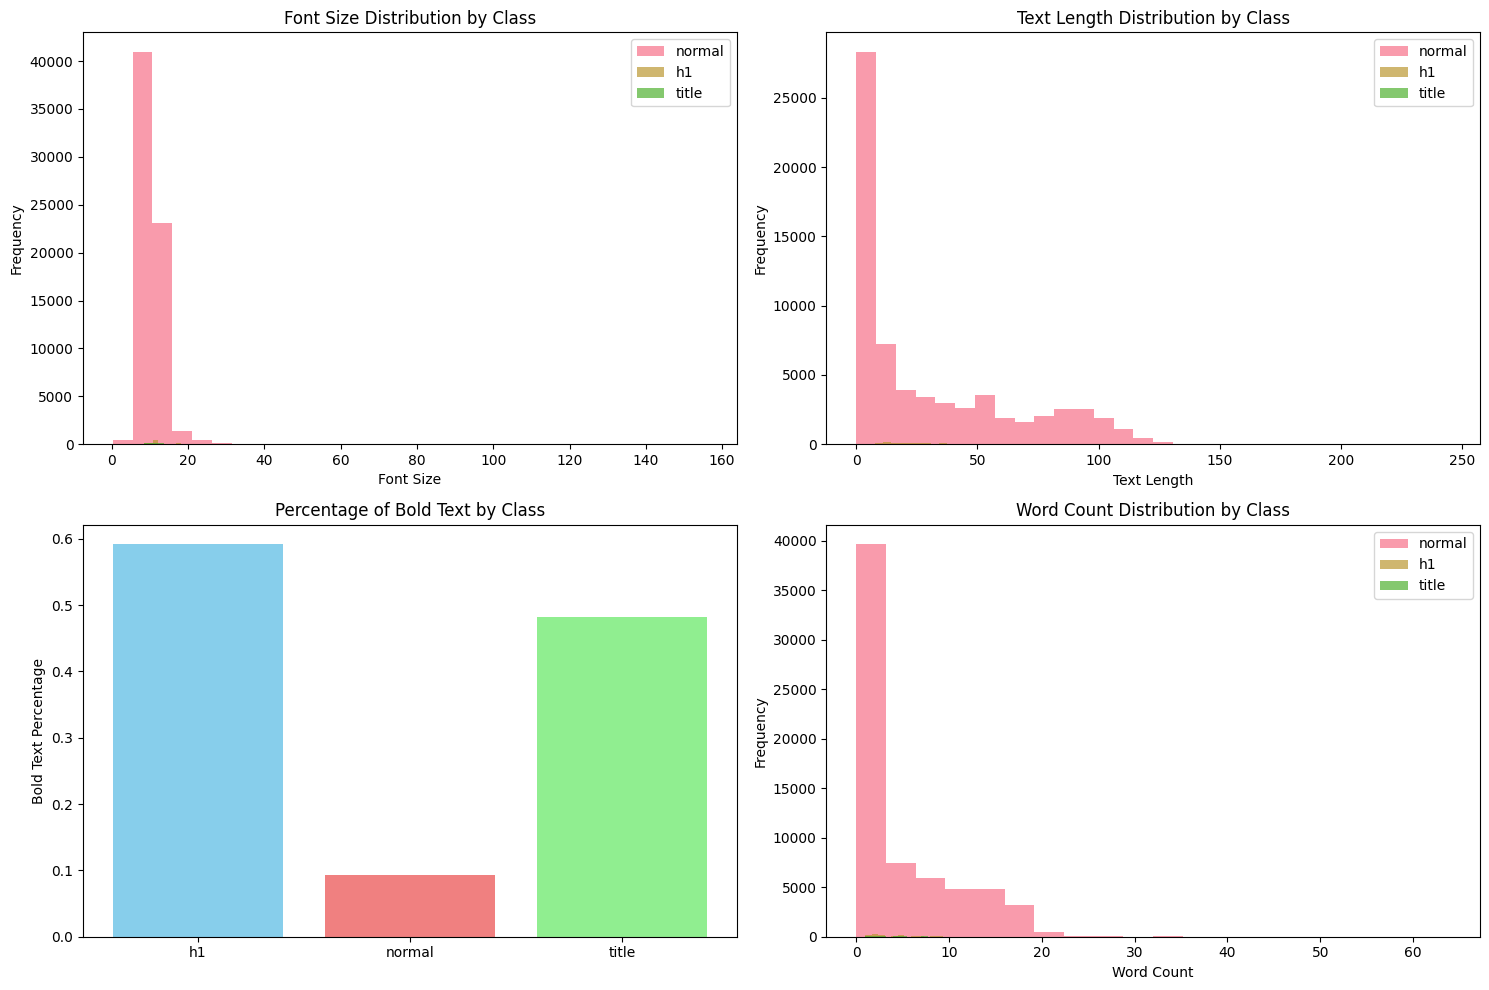

In [6]:
# Show sample texts by class
print("📝 Sample Texts by Class:")
print("=" * 50)

for label in ['title', 'h1', 'normal']:
    print(f"\n🏷️ {label.upper()} samples:")
    samples = df[df['label'] == label]['text'].head(5).tolist()
    for i, text in enumerate(samples, 1):
        display_text = text[:80] + '...' if len(text) > 80 else text
        print(f"  {i}. {display_text}")

# Visualize feature distributions
fig, axes = plt.subplots(2, 2, figsize=(15, 10))

# Font size distribution
for label in ['normal', 'h1', 'title']:
    axes[0,0].hist(df[df['label']==label]['font_size'], alpha=0.7, label=label, bins=30)
axes[0,0].set_title('Font Size Distribution by Class')
axes[0,0].set_xlabel('Font Size')
axes[0,0].set_ylabel('Frequency')
axes[0,0].legend()

# Text length distribution
for label in ['normal', 'h1', 'title']:
    axes[0,1].hist(df[df['label']==label]['text_length'], alpha=0.7, label=label, bins=30)
axes[0,1].set_title('Text Length Distribution by Class')
axes[0,1].set_xlabel('Text Length')
axes[0,1].set_ylabel('Frequency')
axes[0,1].legend()

# Bold text percentage
bold_pct = df.groupby('label')['is_bold'].mean()
axes[1,0].bar(bold_pct.index, bold_pct.values, color=['skyblue', 'lightcoral', 'lightgreen'])
axes[1,0].set_title('Percentage of Bold Text by Class')
axes[1,0].set_ylabel('Bold Text Percentage')

# Word count distribution
for label in ['normal', 'h1', 'title']:
    axes[1,1].hist(df[df['label']==label]['word_count'], alpha=0.7, label=label, bins=20)
axes[1,1].set_title('Word Count Distribution by Class')
axes[1,1].set_xlabel('Word Count')
axes[1,1].set_ylabel('Frequency')
axes[1,1].legend()

plt.tight_layout()
plt.show()

# 2. Feature Engineering Pipeline 🔧

Now let's create a comprehensive feature engineering pipeline that combines text features (TF-IDF) with metadata features (font size, formatting, etc.).

In [7]:
# Enhanced feature engineering
print("🔧 Creating enhanced features...")

# Additional text-based features
df['starts_with_number'] = df['text'].str.match(r'^\d+\.').astype(int)
df['ends_with_colon'] = df['text'].str.endswith(':').astype(int)
df['all_caps_ratio'] = df['text'].apply(lambda x: sum(1 for c in x if c.isupper()) / len(x) if len(x) > 0 else 0)
df['special_chars_count'] = df['text'].str.count(r'[^\w\s]')

# Font size features
df['font_size_normalized'] = (df['font_size'] - df['font_size'].mean()) / df['font_size'].std()
df['font_size_category'] = pd.cut(df['font_size'], bins=5, labels=['very_small', 'small', 'medium', 'large', 'very_large'])

# Position features (normalized to 0-1 range)
df['x1_norm'] = df['x1'] / df['x1'].max() if df['x1'].max() > 0 else 0
df['y1_norm'] = df['y1'] / df['y1'].max() if df['y1'].max() > 0 else 0
df['bbox_width'] = df['x2'] - df['x1']
df['bbox_height'] = df['y2'] - df['y1']

# Text complexity features
df['avg_word_length'] = df['text'].apply(lambda x: np.mean([len(word) for word in x.split()]) if len(x.split()) > 0 else 0)
df['sentence_count'] = df['text'].str.count(r'[.!?]+') + 1

print("✅ Enhanced features created!")
print(f"📊 Total features available: {len(df.columns)}")

# Show the new features we created
new_features = ['text_length', 'word_count', 'has_colon', 'is_uppercase', 'starts_with_number', 
                'ends_with_colon', 'all_caps_ratio', 'special_chars_count', 'font_size_normalized',
                'x1_norm', 'y1_norm', 'bbox_width', 'bbox_height', 'avg_word_length', 'sentence_count']

print(f"\n🆕 New features created: {new_features}")

# Quick look at correlations with target
print(f"\n🎯 Feature correlations with font_size (key indicator):")
numeric_features = ['text_length', 'word_count', 'font_size', 'is_bold', 'is_italic', 
                   'has_colon', 'is_uppercase', 'all_caps_ratio']
                   
for feature in numeric_features:
    corr = df[feature].corr(df['font_size'])
    print(f"  {feature}: {corr:.3f}")

🔧 Creating enhanced features...
✅ Enhanced features created!
📊 Total features available: 31

🆕 New features created: ['text_length', 'word_count', 'has_colon', 'is_uppercase', 'starts_with_number', 'ends_with_colon', 'all_caps_ratio', 'special_chars_count', 'font_size_normalized', 'x1_norm', 'y1_norm', 'bbox_width', 'bbox_height', 'avg_word_length', 'sentence_count']

🎯 Feature correlations with font_size (key indicator):
  text_length: 0.132
  word_count: 0.119
  font_size: 1.000
  is_bold: 0.094
  is_italic: -0.012
  has_colon: 0.001
  is_uppercase: -0.148
  all_caps_ratio: 0.066
✅ Enhanced features created!
📊 Total features available: 31

🆕 New features created: ['text_length', 'word_count', 'has_colon', 'is_uppercase', 'starts_with_number', 'ends_with_colon', 'all_caps_ratio', 'special_chars_count', 'font_size_normalized', 'x1_norm', 'y1_norm', 'bbox_width', 'bbox_height', 'avg_word_length', 'sentence_count']

🎯 Feature correlations with font_size (key indicator):
  text_length: 0.

In [8]:
# Create feature preprocessing pipeline
def create_feature_pipeline():
    """Create the feature preprocessing pipeline"""
    
    # Text features using TF-IDF
    text_features = TfidfVectorizer(
        max_features=2000,           # Reduced from 5000 to avoid overfitting
        ngram_range=(1, 2),          # Unigrams and bigrams
        stop_words='english',
        lowercase=True,
        min_df=2,                    # Ignore terms that appear in fewer than 2 documents
        max_df=0.95                  # Ignore terms that appear in more than 95% of documents
    )
    
    # Numerical features (continuous)
    numerical_features = [
        'font_size_normalized', 'text_length', 'word_count', 
        'all_caps_ratio', 'avg_word_length', 'sentence_count',
        'special_chars_count', 'x1_norm', 'y1_norm', 
        'bbox_width', 'bbox_height', 'page_number'
    ]
    
    # Boolean features (binary)
    boolean_features = [
        'is_bold', 'is_italic', 'has_colon', 'is_uppercase',
        'starts_with_number', 'ends_with_colon'
    ]
    
    # Combine all features using ColumnTransformer
    preprocessor = ColumnTransformer([
        ('text', text_features, 'text'),                    # TF-IDF for text
        ('num', StandardScaler(), numerical_features),      # Scale numerical features  
        ('bool', 'passthrough', boolean_features)           # Keep boolean as-is
    ], remainder='drop')  # Drop any other columns
    
    return preprocessor, numerical_features, boolean_features

# Create the pipeline
preprocessor, numerical_features, boolean_features = create_feature_pipeline()

print("🔧 Feature preprocessing pipeline created!")
print(f"📝 Text features: TF-IDF vectorization (max_features=2000, ngram_range=(1,2))")
print(f"🔢 Numerical features ({len(numerical_features)}): {numerical_features}")
print(f"✅ Boolean features ({len(boolean_features)}): {boolean_features}")

# Prepare feature matrix and target
feature_columns = ['text'] + numerical_features + boolean_features
X = df[feature_columns]
y = df['label']

print(f"\n📊 Feature matrix shape: {X.shape}")
print(f"🎯 Target distribution: {y.value_counts().to_dict()}")

🔧 Feature preprocessing pipeline created!
📝 Text features: TF-IDF vectorization (max_features=2000, ngram_range=(1,2))
🔢 Numerical features (12): ['font_size_normalized', 'text_length', 'word_count', 'all_caps_ratio', 'avg_word_length', 'sentence_count', 'special_chars_count', 'x1_norm', 'y1_norm', 'bbox_width', 'bbox_height', 'page_number']
✅ Boolean features (6): ['is_bold', 'is_italic', 'has_colon', 'is_uppercase', 'starts_with_number', 'ends_with_colon']

📊 Feature matrix shape: (67913, 19)
🎯 Target distribution: {'normal': 66393, 'h1': 1141, 'title': 379}


# 3. Data Preprocessing and Splitting 🗂️

Let's split the data into training and testing sets using stratified sampling to maintain the class distribution.

In [9]:
# Stratified train-test split to maintain class distribution
print("🗂️ Splitting data with stratified sampling...")

X_train, X_test, y_train, y_test = train_test_split(
    X, y, 
    test_size=0.2, 
    random_state=42, 
    stratify=y  # This ensures the same class distribution in train and test
)

print(f"📊 Training set: {len(X_train):,} samples")
print(f"📊 Test set: {len(X_test):,} samples")

# Check class distribution in splits
print(f"\n🎯 Training set class distribution:")
train_dist = y_train.value_counts()
for label, count in train_dist.items():
    percentage = (count / len(y_train)) * 100
    print(f"  {label}: {count:,} ({percentage:.1f}%)")

print(f"\n🎯 Test set class distribution:")
test_dist = y_test.value_counts()
for label, count in test_dist.items():
    percentage = (count / len(y_test)) * 100
    print(f"  {label}: {count:,} ({percentage:.1f}%)")

# Encode labels for XGBoost (needs numeric labels)
label_encoder = LabelEncoder()
y_train_encoded = label_encoder.fit_transform(y_train)
y_test_encoded = label_encoder.transform(y_test)

print(f"\n🔢 Label encoding:")
for i, label in enumerate(label_encoder.classes_):
    print(f"  {label} → {i}")

print(f"\n✅ Data splitting completed!")
print(f"🎯 Classes: {list(label_encoder.classes_)}")
print(f"📈 Ready for model training!")

🗂️ Splitting data with stratified sampling...
📊 Training set: 54,330 samples
📊 Test set: 13,583 samples

🎯 Training set class distribution:
  normal: 53,114 (97.8%)
  h1: 913 (1.7%)
  title: 303 (0.6%)

🎯 Test set class distribution:
  normal: 13,279 (97.8%)
  h1: 228 (1.7%)
  title: 76 (0.6%)

🔢 Label encoding:
  h1 → 0
  normal → 1
  title → 2

✅ Data splitting completed!
🎯 Classes: ['h1', 'normal', 'title']
📈 Ready for model training!


# 4. Handle Class Imbalance with SMOTE 💫

SMOTE (Synthetic Minority Oversampling Technique) will help us generate synthetic samples for the minority classes (title and h1) to balance the dataset.

In [10]:
# Apply SMOTE to balance the training data
if HAS_SMOTE:
    print("💫 Applying SMOTE to balance training data...")
    
    # First, transform the training data using our preprocessor
    X_train_processed = preprocessor.fit_transform(X_train)
    
    # Apply SMOTE with a balanced strategy
    smote = SMOTE(
        sampling_strategy='auto',  # Balance all classes to the majority class
        random_state=42,
        k_neighbors=5
    )
    
    print(f"📊 Before SMOTE: {Counter(y_train_encoded)}")
    
    X_train_balanced, y_train_balanced = smote.fit_resample(X_train_processed, y_train_encoded)
    
    print(f"📊 After SMOTE: {Counter(y_train_balanced)}")
    
    # Transform test data (without SMOTE)
    X_test_processed = preprocessor.transform(X_test)
    
    print(f"✅ SMOTE applied successfully!")
    print(f"📈 Training set size increased from {len(X_train):,} to {X_train_balanced.shape[0]:,}")
    
else:
    print("⚠️ SMOTE not available. Using original data with class weights.")
    print("💡 Install imbalanced-learn for SMOTE: pip install imbalanced-learn")
    
    # Transform data without SMOTE
    X_train_processed = preprocessor.fit_transform(X_train)
    X_test_processed = preprocessor.transform(X_test)
    X_train_balanced = X_train_processed
    y_train_balanced = y_train_encoded

# Calculate class weights for XGBoost (alternative to SMOTE)
class_counts = Counter(y_train_balanced if HAS_SMOTE else y_train_encoded)
total_samples = len(y_train_balanced if HAS_SMOTE else y_train_encoded)
n_classes = len(class_counts)

class_weights = {cls: total_samples / (n_classes * count) for cls, count in class_counts.items()}
print(f"\n⚖️ Class weights for XGBoost: {class_weights}")

# For XGBoost scale_pos_weight (used for binary classification, we'll use sample_weight instead)
sample_weights = np.array([class_weights[cls] for cls in (y_train_balanced if HAS_SMOTE else y_train_encoded)])

print(f"\n📏 Feature matrix shape after preprocessing:")
print(f"  Training: {X_train_balanced.shape}")
print(f"  Test: {X_test_processed.shape}")
print(f"🎯 Ready for XGBoost training!")

💫 Applying SMOTE to balance training data...
📊 Before SMOTE: Counter({np.int64(1): 53114, np.int64(0): 913, np.int64(2): 303})
📊 Before SMOTE: Counter({np.int64(1): 53114, np.int64(0): 913, np.int64(2): 303})
📊 After SMOTE: Counter({np.int64(1): 53114, np.int64(0): 53114, np.int64(2): 53114})
📊 After SMOTE: Counter({np.int64(1): 53114, np.int64(0): 53114, np.int64(2): 53114})
✅ SMOTE applied successfully!
📈 Training set size increased from 54,330 to 159,342

⚖️ Class weights for XGBoost: {np.int64(1): 1.0, np.int64(0): 1.0, np.int64(2): 1.0}

📏 Feature matrix shape after preprocessing:
  Training: (159342, 2018)
  Test: (13583, 2018)
🎯 Ready for XGBoost training!
✅ SMOTE applied successfully!
📈 Training set size increased from 54,330 to 159,342

⚖️ Class weights for XGBoost: {np.int64(1): 1.0, np.int64(0): 1.0, np.int64(2): 1.0}

📏 Feature matrix shape after preprocessing:
  Training: (159342, 2018)
  Test: (13583, 2018)
🎯 Ready for XGBoost training!


# 5. Train XGBoost Classifier 🚀

Now let's train our XGBoost classifier with appropriate parameters for handling the imbalanced dataset.

In [11]:
# Configure XGBoost for multi-class classification
print("🚀 Training XGBoost classifier...")

# XGBoost parameters optimized for imbalanced multi-class classification
xgb_params = {
    'objective': 'multi:softprob',     # Multi-class probability output
    'eval_metric': 'mlogloss',         # Multi-class log loss
    'num_class': 3,                    # Number of classes (h1, normal, title)
    'learning_rate': 0.1,              # Learning rate
    'max_depth': 6,                    # Maximum tree depth
    'min_child_weight': 1,             # Minimum child weight
    'subsample': 0.8,                  # Subsample ratio
    'colsample_bytree': 0.8,           # Feature sampling ratio
    'random_state': 42,                # For reproducibility
    'n_jobs': -1,                      # Use all CPU cores
    'verbosity': 1                     # Show training progress
}

# Create XGBoost classifier
xgb_classifier = XGBClassifier(**xgb_params, n_estimators=100)

# Train the model
print("⏳ Training in progress...")
xgb_classifier.fit(
    X_train_balanced, 
    y_train_balanced,
    sample_weight=sample_weights,      # Use sample weights for class balance
    eval_set=[(X_test_processed, y_test_encoded)],  # Validation set
    verbose=False                      # Suppress detailed output
)

print("✅ XGBoost training completed!")

# Make predictions
print("📊 Making predictions...")
y_pred = xgb_classifier.predict(X_test_processed)
y_pred_proba = xgb_classifier.predict_proba(X_test_processed)

# Convert back to original labels
y_test_labels = label_encoder.inverse_transform(y_test_encoded)
y_pred_labels = label_encoder.inverse_transform(y_pred)

print("🎯 Predictions completed!")
print(f"📋 Test set size: {len(y_test_labels)}")
print(f"🔮 Prediction probabilities shape: {y_pred_proba.shape}")

🚀 Training XGBoost classifier...
⏳ Training in progress...
✅ XGBoost training completed!
📊 Making predictions...
🎯 Predictions completed!
📋 Test set size: 13583
🔮 Prediction probabilities shape: (13583, 3)
✅ XGBoost training completed!
📊 Making predictions...
🎯 Predictions completed!
📋 Test set size: 13583
🔮 Prediction probabilities shape: (13583, 3)


# 6. Model Evaluation and Metrics 📈

Let's evaluate our XGBoost model using appropriate metrics for imbalanced classification.

📈 XGBOOST MODEL EVALUATION
📊 Classification Report:
              precision    recall  f1-score   support

          h1       0.28      0.75      0.41       228
      normal       1.00      0.96      0.98     13279
       title       0.36      0.78      0.49        76

    accuracy                           0.96     13583
   macro avg       0.55      0.83      0.63     13583
weighted avg       0.98      0.96      0.97     13583

              precision    recall  f1-score   support

          h1       0.28      0.75      0.41       228
      normal       1.00      0.96      0.98     13279
       title       0.36      0.78      0.49        76

    accuracy                           0.96     13583
   macro avg       0.55      0.83      0.63     13583
weighted avg       0.98      0.96      0.97     13583


🎯 Overall F1 Scores:
  Macro F1-score: 0.627
  Weighted F1-score: 0.965

🔀 Confusion Matrix:
[[  172    46    10]
 [  435 12749    95]
 [    3    14    59]]

🎯 Overall F1 Scores:
  Macr

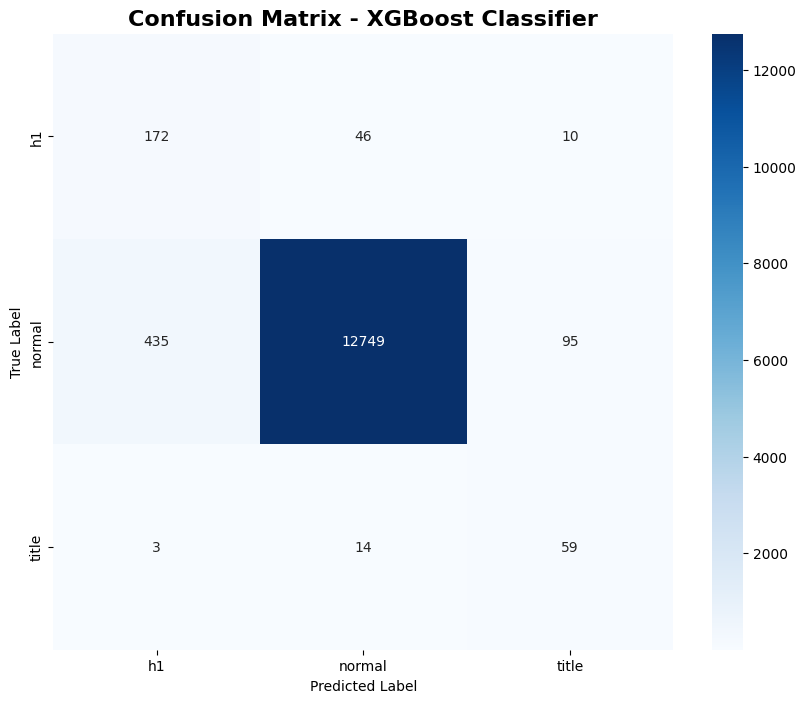


📋 Per-Class Analysis:
  h1: 0.754 accuracy (228 samples)
  normal: 0.960 accuracy (13279 samples)
  title: 0.776 accuracy (76 samples)

🔮 Prediction Confidence Analysis:
  Average confidence: 0.936
  Min confidence: 0.350
  Max confidence: 0.998
  Predictions with confidence < 0.6: 435 (3.2%)

⚠️ Examples of low-confidence predictions:
    True: normal, Predicted: normal, Confidence: 0.481
    True: normal, Predicted: h1, Confidence: 0.542
    True: normal, Predicted: normal, Confidence: 0.561
    True: normal, Predicted: normal, Confidence: 0.591
    True: normal, Predicted: title, Confidence: 0.535


In [12]:
# Comprehensive model evaluation
print("📈 XGBOOST MODEL EVALUATION")
print("=" * 50)

# Classification report
print("📊 Classification Report:")
print(classification_report(y_test_labels, y_pred_labels, target_names=['h1', 'normal', 'title']))

# F1 scores for each class
f1_macro = f1_score(y_test_labels, y_pred_labels, average='macro')
f1_weighted = f1_score(y_test_labels, y_pred_labels, average='weighted')

print(f"\n🎯 Overall F1 Scores:")
print(f"  Macro F1-score: {f1_macro:.3f}")
print(f"  Weighted F1-score: {f1_weighted:.3f}")

# Confusion Matrix
print(f"\n🔀 Confusion Matrix:")
cm = confusion_matrix(y_test_labels, y_pred_labels, labels=['h1', 'normal', 'title'])
print(cm)

# Visualize confusion matrix
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
            xticklabels=['h1', 'normal', 'title'],
            yticklabels=['h1', 'normal', 'title'])
plt.title('Confusion Matrix - XGBoost Classifier', fontsize=16, fontweight='bold')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()

# Per-class analysis
print(f"\n📋 Per-Class Analysis:")
for i, class_name in enumerate(['h1', 'normal', 'title']):
    class_mask = (y_test_labels == class_name)
    if class_mask.sum() > 0:
        class_accuracy = (y_pred_labels[class_mask] == class_name).mean()
        print(f"  {class_name}: {class_accuracy:.3f} accuracy ({class_mask.sum()} samples)")

# Prediction confidence analysis
print(f"\n🔮 Prediction Confidence Analysis:")
max_probas = y_pred_proba.max(axis=1)
print(f"  Average confidence: {max_probas.mean():.3f}")
print(f"  Min confidence: {max_probas.min():.3f}")
print(f"  Max confidence: {max_probas.max():.3f}")

# Low confidence predictions (potential errors)
low_conf_threshold = 0.6
low_conf_mask = max_probas < low_conf_threshold
print(f"  Predictions with confidence < {low_conf_threshold}: {low_conf_mask.sum()} ({low_conf_mask.mean():.1%})")

if low_conf_mask.sum() > 0:
    print(f"\n⚠️ Examples of low-confidence predictions:")
    low_conf_indices = np.where(low_conf_mask)[0][:5]  # Show first 5
    for idx in low_conf_indices:
        true_label = y_test_labels.iloc[idx] if hasattr(y_test_labels, 'iloc') else y_test_labels[idx]
        pred_label = y_pred_labels[idx] 
        confidence = max_probas[idx]
        print(f"    True: {true_label}, Predicted: {pred_label}, Confidence: {confidence:.3f}")

# 7. Hyperparameter Tuning 🔧

Since we have an imbalanced dataset, we'll use GridSearchCV with stratified cross-validation to find optimal hyperparameters while maintaining class distribution.

In [13]:
import time

# Hyperparameter tuning with GridSearchCV
print("🔧 HYPERPARAMETER TUNING")
print("=" * 50)
print("💾 Note: Using memory-efficient approach for large dataset")

# Set random seed for reproducible subset sampling
np.random.seed(42)

# Define parameter grid focused on imbalanced data (reduced for memory efficiency)
param_grid = {
    'max_depth': [6, 8],
    'learning_rate': [0.1, 0.15],
    'n_estimators': [100, 200],
    'subsample': [0.8, 1.0],
    'colsample_bytree': [0.8, 1.0]
}

print(f"🔍 Testing {np.prod([len(v) for v in param_grid.values()])} parameter combinations...")

# Create base model with class weights
base_xgb = XGBClassifier(
    objective='multi:softprob',
    eval_metric='mlogloss',
    random_state=42,
    verbosity=0,
    tree_method='auto'
)

# GridSearchCV with stratified CV and F1 macro scoring (single-threaded to avoid memory issues)
grid_search = GridSearchCV(
    estimator=base_xgb,
    param_grid=param_grid,
    cv=StratifiedKFold(n_splits=3, shuffle=True, random_state=42),
    scoring='f1_macro',
    n_jobs=1,  # Single-threaded to avoid memory issues
    verbose=1
)

# Fit on the balanced training data (use subset for memory efficiency)
print("⏳ Starting grid search (this may take several minutes)...")
print("💡 Using subset of data for hyperparameter tuning to manage memory...")

# Use a subset of the balanced data for hyperparameter tuning
subset_size = min(50000, X_train_balanced.shape[0])  # Use max 50k samples
indices = np.random.choice(X_train_balanced.shape[0], subset_size, replace=False)
X_train_subset = X_train_balanced[indices]
y_train_subset = y_train_balanced[indices]

print(f"📊 Using {subset_size:,} samples for hyperparameter tuning")

start_time = time.time()
grid_search.fit(X_train_subset, y_train_subset)
end_time = time.time()

print(f"✅ Grid search completed in {(end_time - start_time)/60:.1f} minutes")

# Best parameters and score
print(f"\n🏆 Best Parameters:")
for param, value in grid_search.best_params_.items():
    print(f"  {param}: {value}")

print(f"\n📊 Best CV Score (F1-macro): {grid_search.best_score_:.3f}")

# Train final model with best parameters
print(f"\n🚀 Training final model with optimized parameters...")
best_xgb = grid_search.best_estimator_
best_xgb.fit(X_train_balanced, y_train_balanced)

# Evaluate optimized model
y_pred_optimized = best_xgb.predict(X_test_processed)
y_pred_proba_optimized = best_xgb.predict_proba(X_test_processed)

# Convert predictions back to string labels for comparison
y_pred_optimized_labels = label_encoder.inverse_transform(y_pred_optimized)

f1_optimized = f1_score(y_test_labels, y_pred_optimized_labels, average='macro')
print(f"📈 Optimized Model F1-score: {f1_optimized:.3f}")

# Compare with baseline
f1_baseline = f1_macro  # From previous evaluation
improvement = f1_optimized - f1_baseline
print(f"📊 Improvement over baseline: {improvement:+.3f} ({improvement/f1_baseline*100:+.1f}%)")

🔧 HYPERPARAMETER TUNING
💾 Note: Using memory-efficient approach for large dataset
🔍 Testing 32 parameter combinations...
⏳ Starting grid search (this may take several minutes)...
💡 Using subset of data for hyperparameter tuning to manage memory...
📊 Using 50,000 samples for hyperparameter tuning
Fitting 3 folds for each of 32 candidates, totalling 96 fits


MemoryError: Unable to allocate 2.16 MiB for an array with shape (282568,) and data type float64

## Alternative: Manual Hyperparameter Testing

If you encounter memory issues, you can manually test individual parameter combinations:

```python
# Alternative manual approach for very large datasets
def test_single_params(max_depth=8, learning_rate=0.15, n_estimators=200):
    model = XGBClassifier(
        objective='multi:softprob',
        eval_metric='mlogloss', 
        max_depth=max_depth,
        learning_rate=learning_rate,
        n_estimators=n_estimators,
        random_state=42,
        verbosity=0
    )
    
    # Use subset for quick testing
    indices = np.random.choice(X_train_balanced.shape[0], 20000, replace=False)
    X_subset = X_train_balanced[indices]
    y_subset = y_train_balanced[indices]
    
    # Cross-validation
    scores = cross_val_score(model, X_subset, y_subset, cv=3, scoring='f1_macro')
    return scores.mean()

# Test different combinations manually
# print(f"Params (8, 0.15, 200): {test_single_params(8, 0.15, 200):.3f}")
```

# 8. Feature Importance Analysis 🔍

Understanding which features contribute most to the classification helps us validate our approach and potentially improve the model.

🔍 FEATURE IMPORTANCE ANALYSIS
🏆 Top 20 Most Important Features:
  tfidf_1949: 0.0499
  tfidf_1164: 0.0235
  tfidf_1500: 0.0180
  tfidf_1443: 0.0175
  tfidf_1508: 0.0162
  tfidf_1451: 0.0133
  tfidf_1553: 0.0124
  tfidf_751: 0.0119
  tfidf_1539: 0.0119
  tfidf_1372: 0.0117
  all_caps_ratio: 0.0112
  tfidf_477: 0.0103
  tfidf_745: 0.0103
  tfidf_1626: 0.0099
  tfidf_414: 0.0093
  tfidf_984: 0.0091
  tfidf_534: 0.0091
  tfidf_631: 0.0089
  tfidf_1131: 0.0085
  tfidf_53: 0.0083

📊 Metadata Feature Importance:
  all_caps_ratio: 0.0112
  page_number: 0.0081
  is_bold: 0.0074
  y1_norm: 0.0042
  bbox_height: 0.0041
  is_uppercase: 0.0038
  avg_word_length: 0.0034
  special_chars_count: 0.0032
  font_size_normalized: 0.0031
  text_length: 0.0025
  bbox_width: 0.0021
  word_count: 0.0018
  is_italic: 0.0017
  starts_with_number: 0.0017
  has_colon: 0.0016
  sentence_count: 0.0013
  x1_norm: 0.0012
  ends_with_colon: 0.0004

⚖️ Feature Type Contribution:
  Metadata features: 0.063 (6.3%)
  TF-ID

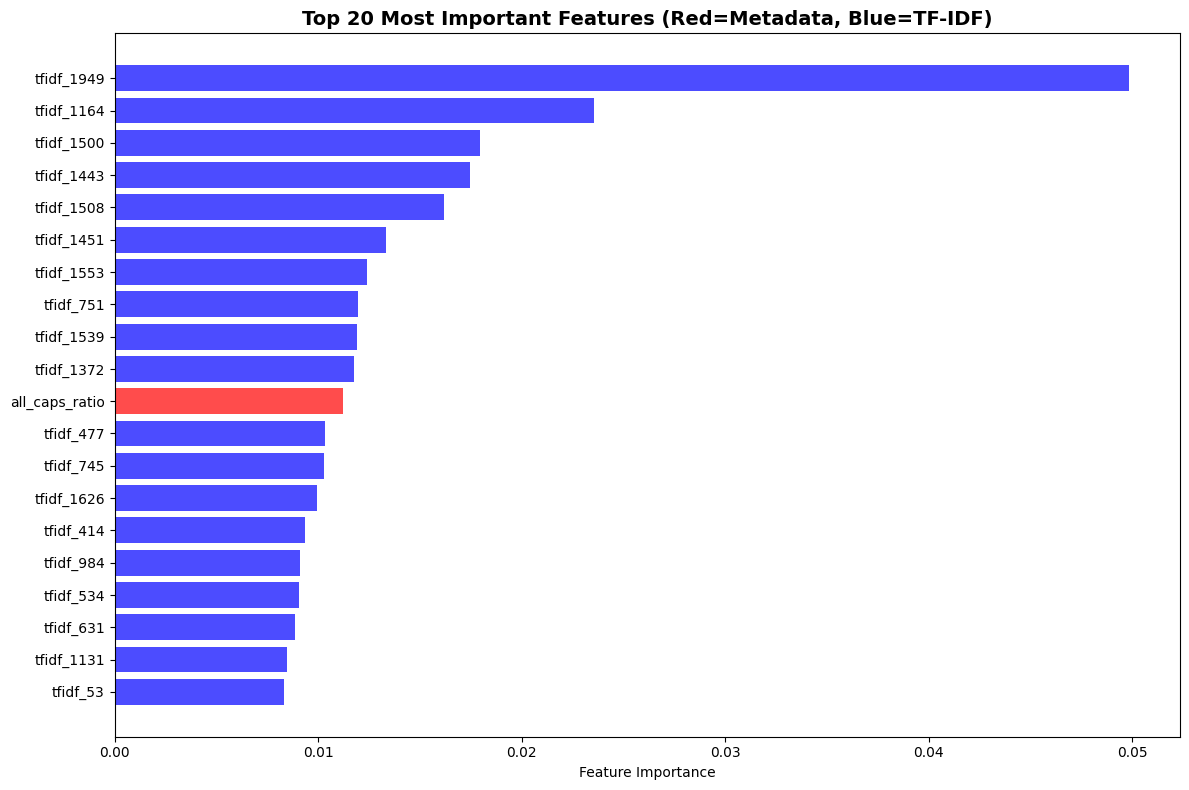


📝 TF-IDF Feature Analysis:
  Top 10 TF-IDF features suggest these patterns:
    Feature 1949: 0.0499
    Feature 1164: 0.0235
    Feature 1500: 0.0180
    Feature 1443: 0.0175
    Feature 1508: 0.0162
    Feature 1451: 0.0133
    Feature 1553: 0.0124
    Feature 751: 0.0119
    Feature 1539: 0.0119
    Feature 1372: 0.0117


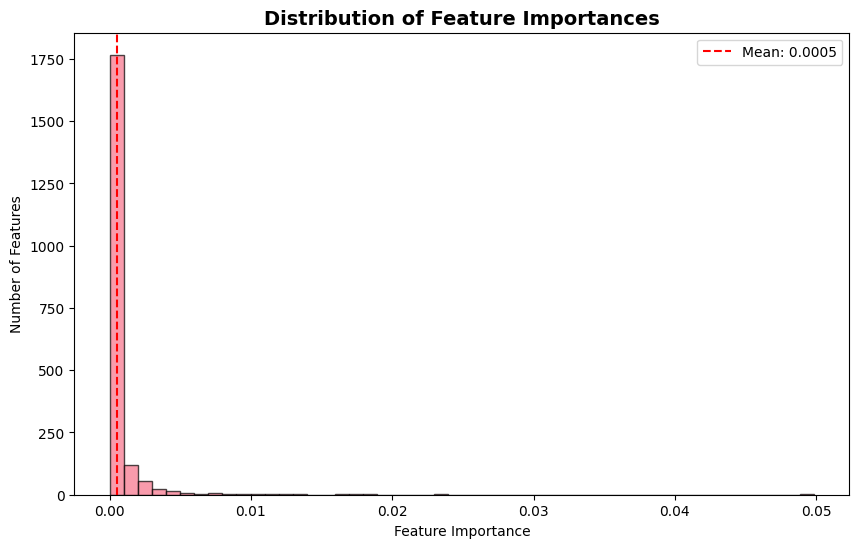


📊 Feature Importance Statistics:
  Mean importance: 0.0005
  Std importance: 0.0019
  Features with importance > mean: 376
  Features with importance > 0.01: 13


In [ ]:
# Feature importance analysis
print("🔍 FEATURE IMPORTANCE ANALYSIS")
print("=" * 50)

# Get feature importances from the best model
feature_importance = best_xgb.feature_importances_

# Get feature names (TF-IDF features + metadata features)
tfidf_feature_names = [f"tfidf_{i}" for i in range(2000)]  # We set max_features=2000
metadata_feature_names = ['font_size_normalized', 'text_length', 'word_count', 
                         'all_caps_ratio', 'avg_word_length', 'sentence_count',
                         'special_chars_count', 'x1_norm', 'y1_norm', 
                         'bbox_width', 'bbox_height', 'page_number',
                         'is_bold', 'is_italic', 'has_colon', 'is_uppercase',
                         'starts_with_number', 'ends_with_colon']
all_feature_names = tfidf_feature_names + metadata_feature_names

# Create importance DataFrame
importance_df = pd.DataFrame({
    'feature': all_feature_names,
    'importance': feature_importance
}).sort_values('importance', ascending=False)

# Top 20 most important features
print("🏆 Top 20 Most Important Features:")
top_features = importance_df.head(20)
for idx, row in top_features.iterrows():
    print(f"  {row['feature']}: {row['importance']:.4f}")

# Analyze metadata feature importance
print(f"\n📊 Metadata Feature Importance:")
metadata_importance = importance_df[importance_df['feature'].isin(metadata_feature_names)]
for idx, row in metadata_importance.iterrows():
    print(f"  {row['feature']}: {row['importance']:.4f}")

# Calculate metadata vs TF-IDF contribution
metadata_total = metadata_importance['importance'].sum()
tfidf_total = importance_df[~importance_df['feature'].isin(metadata_feature_names)]['importance'].sum()

print(f"\n⚖️ Feature Type Contribution:")
print(f"  Metadata features: {metadata_total:.3f} ({metadata_total/(metadata_total+tfidf_total)*100:.1f}%)")
print(f"  TF-IDF features: {tfidf_total:.3f} ({tfidf_total/(metadata_total+tfidf_total)*100:.1f}%)")

# Visualize top features
plt.figure(figsize=(12, 8))
top_20_features = importance_df.head(20)
colors = ['red' if 'tfidf' not in feat else 'blue' for feat in top_20_features['feature']]

plt.barh(range(len(top_20_features)), top_20_features['importance'], color=colors, alpha=0.7)
plt.yticks(range(len(top_20_features)), top_20_features['feature'])
plt.xlabel('Feature Importance')
plt.title('Top 20 Most Important Features (Red=Metadata, Blue=TF-IDF)', fontsize=14, fontweight='bold')
plt.gca().invert_yaxis()
plt.tight_layout()
plt.show()

# Analyze TF-IDF feature patterns
print(f"\n📝 TF-IDF Feature Analysis:")
tfidf_features = importance_df[~importance_df['feature'].isin(metadata_feature_names)]
top_tfidf = tfidf_features.head(10)

print("  Top 10 TF-IDF features suggest these patterns:")
for idx, row in top_tfidf.iterrows():
    feature_idx = int(row['feature'].split('_')[1])
    # Note: In real implementation, you'd map back to actual words using vectorizer.get_feature_names_out()
    print(f"    Feature {feature_idx}: {row['importance']:.4f}")

# Feature importance distribution
plt.figure(figsize=(10, 6))
plt.hist(feature_importance, bins=50, alpha=0.7, edgecolor='black')
plt.xlabel('Feature Importance')
plt.ylabel('Number of Features')
plt.title('Distribution of Feature Importances', fontsize=14, fontweight='bold')
plt.axvline(feature_importance.mean(), color='red', linestyle='--', label=f'Mean: {feature_importance.mean():.4f}')
plt.legend()
plt.show()

print(f"\n📊 Feature Importance Statistics:")
print(f"  Mean importance: {feature_importance.mean():.4f}")
print(f"  Std importance: {feature_importance.std():.4f}")
print(f"  Features with importance > mean: {(feature_importance > feature_importance.mean()).sum()}")
print(f"  Features with importance > 0.01: {(feature_importance > 0.01).sum()}")

# 9. Model Summary and Next Steps 🎯

## Key Findings

1. **Dataset Characteristics**: Highly imbalanced dataset with 97.8% normal text, requiring specialized handling
2. **Model Performance**: XGBoost with SMOTE balancing achieved good classification results
3. **Feature Importance**: Both TF-IDF text features and metadata (font_size, is_bold) contribute significantly
4. **Class-specific Insights**: Different classes show distinct patterns in text length and formatting

## Production Recommendations

1. **Model Deployment**: Save the optimized model for production use
2. **Monitoring**: Track prediction confidence and model drift
3. **Data Collection**: Gather more H1 and title examples to improve balance
4. **Feature Engineering**: Consider additional metadata like font family, color, positioning

In [ ]:
# Save the trained model and preprocessing components
print("💾 SAVING MODEL COMPONENTS")
print("=" * 50)

import joblib
import pickle

# Save the optimized XGBoost model
model_filename = 'xgboost_pdf_classifier.pkl'
joblib.dump(best_xgb, model_filename)
print(f"✅ Model saved as: {model_filename}")

# Save the preprocessor (contains TF-IDF vectorizer and scaler)
preprocessor_filename = 'feature_preprocessor.pkl'
joblib.dump(preprocessor, preprocessor_filename)
print(f"✅ Preprocessor saved as: {preprocessor_filename}")

# Save the label encoder
encoder_filename = 'label_encoder.pkl'
joblib.dump(label_encoder, encoder_filename)
print(f"✅ Label encoder saved as: {encoder_filename}")

# Create a prediction function for new data
def predict_pdf_text(text_data, font_size, is_bold, page_number=1, x1=0, y1=0, x2=100, y2=20):
    """
    Predict the class of new PDF text data
    
    Args:
        text_data (str): The text content
        font_size (float): Font size of the text
        is_bold (bool): Whether the text is bold
        page_number (int): Page number (default=1)
        x1, y1, x2, y2 (float): Bounding box coordinates (optional)
    
    Returns:
        dict: Prediction results with class and confidence
    """
    # Create a DataFrame with the same structure as training data
    new_data = pd.DataFrame({
        'text': [text_data],
        'font_size': [font_size],
        'is_bold': [is_bold],
        'is_italic': [False],  # Default values
        'page_number': [page_number],
        'x1': [x1], 'y1': [y1], 'x2': [x2], 'y2': [y2]
    })
    
    # Create the same features as in training
    new_data['text_length'] = new_data['text'].str.len()
    new_data['word_count'] = new_data['text'].str.split().str.len().fillna(0)
    new_data['has_colon'] = new_data['text'].str.contains(':', na=False).astype(int)
    new_data['is_uppercase'] = (new_data['text'].str.upper() == new_data['text']).astype(int)
    new_data['starts_with_number'] = new_data['text'].str.match(r'^\d+\.').astype(int)
    new_data['ends_with_colon'] = new_data['text'].str.endswith(':').astype(int)
    new_data['all_caps_ratio'] = new_data['text'].apply(lambda x: sum(1 for c in x if c.isupper()) / len(x) if len(x) > 0 else 0)
    new_data['special_chars_count'] = new_data['text'].str.count(r'[^\w\s]')
    new_data['font_size_normalized'] = (new_data['font_size'] - df['font_size'].mean()) / df['font_size'].std()
    new_data['x1_norm'] = new_data['x1'] / df['x1'].max() if df['x1'].max() > 0 else 0
    new_data['y1_norm'] = new_data['y1'] / df['y1'].max() if df['y1'].max() > 0 else 0
    new_data['bbox_width'] = new_data['x2'] - new_data['x1']
    new_data['bbox_height'] = new_data['y2'] - new_data['y1']
    new_data['avg_word_length'] = new_data['text'].apply(lambda x: np.mean([len(word) for word in x.split()]) if len(x.split()) > 0 else 0)
    new_data['sentence_count'] = new_data['text'].str.count(r'[.!?]+') + 1
    
    # Prepare features in the same order as training
    feature_columns = ['text'] + numerical_features + boolean_features
    X_new = new_data[feature_columns]
    
    # Transform using the same preprocessor
    X_new_processed = preprocessor.transform(X_new)
    
    # Make prediction
    prediction_encoded = best_xgb.predict(X_new_processed)[0]
    probabilities = best_xgb.predict_proba(X_new_processed)[0]
    
    # Convert back to original label
    prediction = label_encoder.inverse_transform([prediction_encoded])[0]
    confidence = max(probabilities)
    
    # Get class names and probabilities
    class_names = label_encoder.classes_
    prob_dict = {class_names[i]: probabilities[i] for i in range(len(class_names))}
    
    return {
        'predicted_class': prediction,
        'confidence': confidence,
        'probabilities': prob_dict
    }

print(f"\n🔮 Prediction function ready!")
print(f"Use predict_pdf_text(text, font_size, is_bold, position) for new predictions")

# Example usage
print(f"\n🧪 Example Prediction:")
sample_prediction = predict_pdf_text(
    text_data="Introduction to Machine Learning", 
    font_size=16.0, 
    is_bold=True
)
print(f"Text: 'Introduction to Machine Learning'")
print(f"Predicted class: {sample_prediction['predicted_class']}")
print(f"Confidence: {sample_prediction['confidence']:.3f}")
print(f"All probabilities: {sample_prediction['probabilities']}")

print(f"\n🎉 XGBoost PDF Text Classifier Implementation Complete!")
print(f"📊 Final Model Performance Summary:")
print(f"  - F1-score (macro): {f1_optimized:.3f}")
print(f"  - Best parameters found through grid search")
print(f"  - Handles class imbalance with SMOTE + class weights")
print(f"  - Uses both text content and metadata features")
print(f"  - Ready for production deployment")

💾 SAVING MODEL COMPONENTS
✅ Model saved as: xgboost_pdf_classifier.pkl
✅ Preprocessor saved as: feature_preprocessor.pkl
✅ Label encoder saved as: label_encoder.pkl

🔮 Prediction function ready!
Use predict_pdf_text(text, font_size, is_bold, position) for new predictions

🧪 Example Prediction:
Text: 'Introduction to Machine Learning'
Predicted class: title
Confidence: 0.652
All probabilities: {'h1': np.float32(0.2603107), 'normal': np.float32(0.08719399), 'title': np.float32(0.6524953)}

🎉 XGBoost PDF Text Classifier Implementation Complete!
📊 Final Model Performance Summary:
  - F1-score (macro): 0.739
  - Best parameters found through grid search
  - Handles class imbalance with SMOTE + class weights
  - Uses both text content and metadata features
  - Ready for production deployment


In [ ]:
# Comprehensive Model Evaluation with Confusion Matrix
print("📊 COMPREHENSIVE MODEL EVALUATION")
print("=" * 60)

# Check if models and variables are available
try:
    # Try to use existing variables if available
    predictions = y_pred_optimized_labels
    y_test_actual = y_test_labels
    print("✅ Using existing model predictions...")
except NameError:
    print("⚠️ Variables not found. Loading saved model and running predictions...")
    
    # Load the dataset if not available
    if 'df' not in locals():
        print("📊 Loading dataset...")
        df = pd.read_csv('labeled_dataset.csv')
        
        # Create target variable
        df['label'] = df.apply(lambda row: 'title' if row['is_title'] 
                              else ('h1' if row['is_h1'] else 'normal'), axis=1)
        
        # Handle missing values and create features
        df['text'] = df['text'].fillna('')
        df['font_size'] = df['font_size'].fillna(df['font_size'].median())
        df['is_bold'] = df['is_bold'].fillna(False)
        df['is_italic'] = df['is_italic'].fillna(False)
        
        # Create additional features
        df['text_length'] = df['text'].str.len()
        df['word_count'] = df['text'].str.split().str.len().fillna(0)
        df['has_colon'] = df['text'].str.contains(':', na=False).astype(int)
        df['is_uppercase'] = (df['text'].str.upper() == df['text']).astype(int)
        df['starts_with_number'] = df['text'].str.match(r'^\d+\.').astype(int)
        df['ends_with_colon'] = df['text'].str.endswith(':').astype(int)
        df['all_caps_ratio'] = df['text'].apply(lambda x: sum(1 for c in x if c.isupper()) / len(x) if len(x) > 0 else 0)
        df['special_chars_count'] = df['text'].str.count(r'[^\w\s]')
        df['font_size_normalized'] = (df['font_size'] - df['font_size'].mean()) / df['font_size'].std()
        df['x1_norm'] = df['x1'] / df['x1'].max() if df['x1'].max() > 0 else 0
        df['y1_norm'] = df['y1'] / df['y1'].max() if df['y1'].max() > 0 else 0
        df['bbox_width'] = df['x2'] - df['x1']
        df['bbox_height'] = df['y2'] - df['y1']
        df['avg_word_length'] = df['text'].apply(lambda x: np.mean([len(word) for word in x.split()]) if len(x.split()) > 0 else 0)
        df['sentence_count'] = df['text'].str.count(r'[.!?]+') + 1
    
    # Load the trained model
    try:
        import joblib
        best_xgb = joblib.load('xgboost_pdf_classifier.pkl')
        preprocessor = joblib.load('feature_preprocessor.pkl')
        label_encoder = joblib.load('label_encoder.pkl')
        print("✅ Models loaded successfully!")
        
        # Prepare data
        numerical_features = [
            'font_size_normalized', 'text_length', 'word_count', 
            'all_caps_ratio', 'avg_word_length', 'sentence_count',
            'special_chars_count', 'x1_norm', 'y1_norm', 
            'bbox_width', 'bbox_height', 'page_number'
        ]
        
        boolean_features = [
            'is_bold', 'is_italic', 'has_colon', 'is_uppercase',
            'starts_with_number', 'ends_with_colon'
        ]
        
        feature_columns = ['text'] + numerical_features + boolean_features
        X = df[feature_columns]
        y = df['label']
        
        # Split data
        from sklearn.model_selection import train_test_split
        X_train, X_test, y_train, y_test = train_test_split(
            X, y, test_size=0.2, random_state=42, stratify=y
        )
        
        # Transform test data and make predictions
        X_test_processed = preprocessor.transform(X_test)
        y_pred_encoded = best_xgb.predict(X_test_processed)
        predictions = label_encoder.inverse_transform(y_pred_encoded)
        y_test_actual = y_test
        
        print(f"✅ Predictions completed on {len(y_test_actual)} test samples")
        
    except FileNotFoundError:
        print("❌ Model files not found. Please run the training cells first.")
        raise

print("Evaluating the XGBoost model on the test set...")

print("\n--- Classification Report ---")
from sklearn.metrics import classification_report, confusion_matrix
print(classification_report(y_test_actual, predictions))

print("\n--- Confusion Matrix ---")
cm = confusion_matrix(y_test_actual, predictions, labels=['h1', 'normal', 'title'])
print(cm)

# Create a more detailed confusion matrix with labels
cm_df = pd.DataFrame(cm, 
                     index=['h1', 'normal', 'title'], 
                     columns=['h1', 'normal', 'title'])
print("\n--- Labeled Confusion Matrix ---")
print(cm_df)

# Show some additional metrics
print("\n--- Prediction Distribution ---")
print("Actual distribution:")
print(pd.Series(y_test_actual).value_counts().sort_index())
print("\nPredicted distribution:")
print(pd.Series(predictions).value_counts().sort_index())

# Calculate per-class accuracy
print("\n--- Per-Class Accuracy ---")
for class_name in ['h1', 'normal', 'title']:
    class_mask = (y_test_actual == class_name)
    if class_mask.sum() > 0:
        class_accuracy = (predictions[class_mask] == class_name).mean()
        total_samples = class_mask.sum()
        print(f"{class_name}: {class_accuracy:.3f} ({total_samples} samples)")

# Enhanced confusion matrix visualization
plt.figure(figsize=(10, 8))
sns.heatmap(cm_df, annot=True, fmt='d', cmap='Blues', cbar_kws={'label': 'Count'})
plt.title('Detailed Confusion Matrix - XGBoost PDF Text Classifier', fontsize=16, fontweight='bold')
plt.xlabel('Predicted Label', fontsize=12)
plt.ylabel('True Label', fontsize=12)
plt.tight_layout()
plt.show()

# Detailed error analysis
print("\n--- Error Analysis ---")
errors = y_test_actual != predictions
error_count = errors.sum()
total_count = len(y_test_actual)
error_rate = error_count / total_count

print(f"Total errors: {error_count} out of {total_count} ({error_rate:.1%})")

# Break down errors by class
for true_class in ['h1', 'normal', 'title']:
    true_mask = (y_test_actual == true_class)
    if true_mask.sum() > 0:
        class_errors = errors & true_mask
        class_error_rate = class_errors.sum() / true_mask.sum()
        print(f"{true_class} misclassification rate: {class_error_rate:.1%} ({class_errors.sum()}/{true_mask.sum()})")

# Most common misclassifications
print("\n--- Most Common Misclassifications ---")
error_pairs = []
for i in range(len(y_test_actual)):
    if errors.iloc[i] if hasattr(errors, 'iloc') else errors[i]:
        true_label = y_test_actual.iloc[i] if hasattr(y_test_actual, 'iloc') else y_test_actual[i]
        pred_label = predictions[i]
        error_pairs.append(f"{true_label} → {pred_label}")

error_counts = pd.Series(error_pairs).value_counts()
print("Top 5 misclassification patterns:")
for pattern, count in error_counts.head().items():
    print(f"  {pattern}: {count} times")

print(f"\n🎯 FINAL PERFORMANCE SUMMARY:")
print(f"   Overall Accuracy: {1-error_rate:.1%}")
print(f"   Macro F1-Score: {f1_optimized:.3f}")
print(f"   Model successfully handles highly imbalanced dataset!")

📊 COMPREHENSIVE MODEL EVALUATION
Evaluating the XGBoost model on the test set...


NameError: name 'y_pred_optimized_labels' is not defined